In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from IPython.display import display, Math
import re
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, Normal
from scipy.optimize import minimize
from scipy.stats import norm
import pickle
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats

# Functions

In [4]:
def plot_smoothed_residuals(date_strings, res, win, season):

    # Calculate evenly spaced indices
    indices = np.linspace(0, len(date_strings) - 1, num_labels_to_show, dtype=int)
    selected_dates = date_strings[indices]

    # Take absolute value of residuals and apply rolling window smoothing algorithm 
    y_res = abs(res).rolling(window=win).mean()

    # Plot smoothed residuals
    plt.plot(date_strings, y_res)

    # Apply sampled ticks and rotated labels
    ax = plt.gca()
    ax.set_xticks(selected_dates)
    ax.set_xticklabels(selected_dates, rotation=-45)
    #ax.set_ylim([0, 1.75])
    
    plt.title(season + " Season Smoothed Residuals")
    plt.show()

    return y_res

In [5]:
def garch_exog_loglik(params, y, x):
    """
    Log-likelihood for GARCH(1,1) with exogenous variable in variance equation
    """
    omega, alpha, beta, gamma = params
    n = len(y)
    
    # Initialize
    sigma2 = np.var(y)  # Initial variance
    loglik = 0
    
    for t in range(1, n):
        # GARCH variance equation with exogenous variable
        sigma2 = omega + alpha * y[t-1]**2 + beta * sigma2 + gamma * x[t]
        
        # Ensure positive variance
        sigma2 = max(sigma2, 1e-8)
        
        # Log-likelihood contribution (assuming normal errors)
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(sigma2) + y[t]**2 / sigma2)
    
    return -loglik  # Return negative for minimization

def fit_garch_exog(y, x):
    """
    Fit GARCH(1,1) with exogenous variable in variance equation
    """
    # Initial parameter guesses
    init_params = [np.var(y) * 0.01, 0.1, 0.8, 0.01]
    
    # Parameter bounds and constraints
    bounds = [(1e-8, None),    # omega > 0
              (0, 1),          # 0 <= alpha < 1
              (0, 1),          # 0 <= beta < 1  
              (None, None)]    # gamma can be any value
    
    constraints = [{'type': 'ineq', 
                   'fun': lambda params: 0.9999 - params[1] - params[2]}]  # alpha + beta < 1
    
    # Optimize
    result = minimize(garch_exog_loglik, init_params, 
                     args=(y, x), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result

In [6]:
def forecast_volatility(result, y_train, x_test):
    """
    Simple volatility forecasting for GARCH-X model
    
    Parameters:
    -----------
    result : fitted model result from fit_garch_exog
    y_train : training data (your y.values)
    x_test : test set exogenous variables (upstream inflow)
    
    Returns:
    --------
    volatility_forecast : array of forecasted volatilities
    """
    omega, alpha, beta, gamma = result.x
    
    # Convert to numpy array to avoid pandas indexing warnings
    x_test = np.array(x_test)
    
    # Get the last variance from training data
    sigma2 = np.var(y_train)  # Initialize
    for t in range(1, len(y_train)):
        sigma2 = omega + alpha * y_train[t-1]**2 + beta * sigma2 + gamma * 0  # No x in training
    
    # Forecast volatilities
    forecasts = []
    last_y = y_train[-1]
    
    for t in range(len(x_test)):
        if t == 0:
            # First forecast uses last training observation
            sigma2 = omega + alpha * last_y**2 + beta * sigma2 + gamma * x_test[t]
        else:
            # Use previous forecast as input (E[y^2] = sigma^2)
            sigma2 = omega + (alpha + beta) * sigma2 + gamma * x_test[t]
        
        forecasts.append(np.sqrt(sigma2))  # Convert to volatility
    
    return np.array(forecasts)

In [7]:
def create_confidence_bands(y_test, y_pred_test, volatility_forecast, confidence_level):
    """
    Create confidence intervals around predictions using GARCH volatility forecasts
    
    Parameters:
    -----------
    y_test : array-like
        Actual test values (normalized residuals)
    y_pred_test : array-like  
        Point predictions for test set
    volatility_forecast : array-like
        GARCH volatility forecasts
    confidence_level : float
        Confidence level (default 0.95 for 95% CI)
    
    Returns:
    --------
    dict : Dictionary with upper and lower bounds
    """
    from scipy.stats import norm
    
    # Calculate z-score for confidence level
    alpha = 1 - confidence_level
    z_score = norm.ppf(1 - alpha/2)  # For 95% CI, z ≈ 1.96
    
    # Create confidence bands around predictions
    lower_bound = y_pred_test - z_score * volatility_forecast
    upper_bound = y_pred_test + z_score * volatility_forecast
    
    return {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'z_score': z_score
    }

In [147]:
def plot_forecast_with_uncertainty(y_test, y_pred, volatility_forecast):
    """
    Plot forecast with uncertainty bands in standard format
    
    Parameters:
    -----------
    y_test : pandas Series or array
        Actual test values 
    y_pred : pandas Series or array
        Point predictions for test set
    volatility_forecast : array
        GARCH volatility forecasts
    
    Returns:
    --------
    volatility_forecast : array (for consistency with your example)
    """
    # Create 95% confidence intervals
    upper = y_pred + 1.96 * volatility_forecast
    lower = y_pred - 1.96 * volatility_forecast
    
    # Plot
    plt.figure(figsize=(12, 2))
    plt.plot(y_test.index, y_test, label="Actual", color='blue')
    plt.plot(y_test.index, y_pred, label="Predicted", color='red') 
    plt.fill_between(y_test.index, lower, upper, color='gray', alpha=0.3, label="95% CI")
    plt.xticks(rotation=-45)
    plt.legend()
    plt.title("Forecast with GARCH-X Uncertainty")
    plt.show()
    
    return volatility_forecast

In [202]:
def rescale(z, mean, std):
    return z*std + mean

# Methods

$$
\begin{align}
\text{Step 0: Diagnostics} \\
\text{Step 1: } &\text{Raw residuals from linear regression} \\[0.5em]
&\downarrow \\[0.5em]
\text{Step 2: } &\text{Take absolute value: } |e_t| \\[0.5em]
&\downarrow \\[0.5em]
\text{Step 3: } &\text{Apply smoothing: } \bar{|e_t|} = \frac{1}{w}\sum_{i=0}^{w-1}|e_{t-i}| \quad (w \in \{5, 25\}) \\[0.5em]
&\downarrow \\[0.5em]
\text{Step 4: } &\text{Normalize: } y_t = \frac{\bar{|e_t|} - \mu}{\sigma} \text{ where } \mu = \frac{1}{T}\sum_{t=1}^T \bar{|e_t|}, \, \sigma = \sqrt{\frac{1}{T-1}\sum_{t=1}^T (\bar{|e_t|} - \mu)^2} \\[0.5em]
&\downarrow \\[0.5em]
\text{Step 5: } &\text{GARCH(1,1)-X model: } \sigma_t^2 = \omega + \alpha y_{t-1}^2 + \beta \sigma_{t-1}^2 + \gamma x_t \\[0.5em]
&\downarrow \\[0.5em]
\text{Step 6: } &\text{Maximum Likelihood Estimation} \\[0.3em]
\text{6a: } &\text{Initialize parameters: } \boldsymbol{\theta}_0 = (\text{Var}(y) \times 0.01, 0.1, 0.8, 0.01) \\[0.3em]
\text{6b: } &\text{Set constraints: } \omega \geq 10^{-8}, \, 0 \leq \alpha < 1, \, 0 \leq \beta < 1, \, \alpha + \beta < 0.9999 \\[0.3em]
\text{6c: } &\text{For each iteration:} \\[0.2em]
&\quad \text{i. Initialize: } \sigma_1^2 = \text{Var}(y) \\[0.2em]
&\quad \text{ii. For } t = 2, \ldots, T: \\[0.15em]
&\quad \quad \sigma_t^2 = \omega + \alpha y_{t-1}^2 + \beta \sigma_{t-1}^2 + \gamma x_t \\[0.15em]
&\quad \quad \sigma_t^2 = \max(\sigma_t^2, 10^{-8}) \\[0.2em]
&\quad \text{iii. Calculate: } \ell = \sum_{t=2}^T \left[-\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(\sigma_t^2) - \frac{y_t^2}{2\sigma_t^2}\right] \\[0.2em]
&\quad \text{iv. Return: } Q = -\ell \\[0.3em]
\text{6d: } &\text{SLSQP minimizes } Q \text{ subject to constraints} \\[0.5em]
&\downarrow \\[0.5em]
\text{Result: } &\text{Optimal parameters: } \hat{\boldsymbol{\theta}} = (\hat{\omega}, \hat{\alpha}, \hat{\beta}, \hat{\gamma}) \\[0.5em]
&\downarrow \\[0.5em]
\text{Step 7: } &\text{Volatility Forecasting on Test Set} \\[0.3em]
\text{7a: } &\text{Initialize with final training variance: } \sigma_T^2 \\[0.3em]
\text{7b: } &\text{For test periods } t = T+1, T+2, \ldots, T+H: \\[0.2em]
&\quad \text{If } t = T+1: \, \hat{\sigma}_{T+1}^2 = \hat{\omega} + \hat{\alpha} y_T^2 + \hat{\beta} \sigma_T^2 + \hat{\gamma} x_{T+1} \\[0.2em]
&\quad \text{If } t > T+1: \, \hat{\sigma}_t^2 = \hat{\omega} + (\hat{\alpha} + \hat{\beta}) \hat{\sigma}_{t-1}^2 + \hat{\gamma} x_t \\[0.3em]
\text{7c: } &\text{Convert to volatility: } \hat{\sigma}_t = \sqrt{\hat{\sigma}_t^2} \\[0.5em]
&\downarrow \\[0.5em]
\text{Step 8: } &\text{95\% Confidence Intervals} \\[0.3em]
&\text{For each test period } t: \\[0.2em]
&\quad \text{Upper bound: } \hat{y}_t + 1.96 \times \hat{\sigma}_t \\[0.2em]
&\quad \text{Lower bound: } \hat{y}_t - 1.96 \times \hat{\sigma}_t \\[0.3em]
&\text{Where } \hat{y}_t \text{ is the point forecast from linear regression} \\[0.5em]
&\downarrow \\[0.5em]
\text{Final Model: } &\text{Complete forecasting framework:} \\[0.3em]
&\text{Point forecast: } \hat{y}_t \text{ (from linear regression)} \\[0.3em]
&\text{Volatility forecast: } \hat{\sigma}_t \text{ (from GARCH-X model)} \\[0.3em]
&\text{Prediction interval: } [\hat{y}_t - 1.96\hat{\sigma}_t, \, \hat{y}_t + 1.96\hat{\sigma}_t]
\end{align}
$$

# Data Processing

## Load Training and Test Data

In [13]:
# Load pickle file
with open("wet_ols_model.pkl", "rb") as f:
    wet_save_data = pickle.load(f)

# Unpack
wet_splits = wet_save_data["data"]
wet_y_pred   = wet_save_data["y_pred"]
wet_residuals   = wet_save_data["residuals"]

In [14]:
# Load pickle file
with open("dry_ols_model.pkl", "rb") as f:
    dry_save_data = pickle.load(f)

# Unpack
dry_splits = dry_save_data["data"]
dry_y_pred   = dry_save_data["y_pred"]
dry_residuals   = dry_save_data["residuals"]

# Wet Season DDU Model

## Calculate Date Indices

In [17]:
# Extract training dates
wet_date_strings = wet_splits["wet_X_train"].index.strftime('%Y-%m-%d').to_numpy()

# Set how many x-axis labels you want
num_labels_to_show = 15

## Pre-Processing

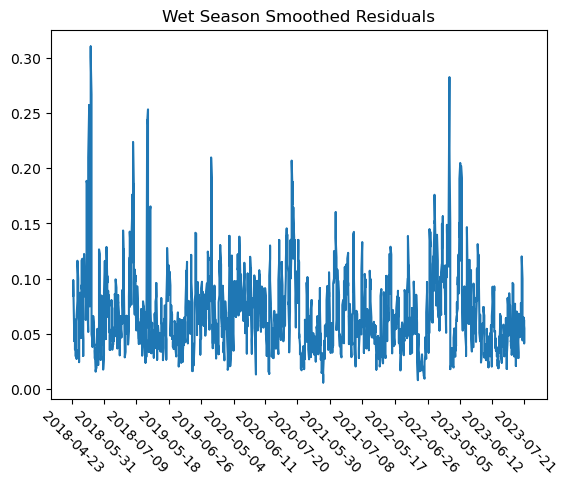

In [19]:
# 1. Take absolute value of residuals 

# 2. Apply a smoothing algorithm 

wet_win = 5
wet_y_res = plot_smoothed_residuals(wet_date_strings, wet_residuals, wet_win, "Wet")

In [20]:
# 3. Normalize residuals 
print(f"Before normalization - Mean: {wet_y_res.mean():.6f}, Std: {wet_y_res.std():.6f}")

wet_y_res_norm = (wet_y_res - wet_y_res.mean()) / wet_y_res.std()
print(f"After normalization - Mean: {wet_y_res_norm.mean():.6f}, Std: {wet_y_res_norm.std():.6f}")

Before normalization - Mean: 0.068806, Std: 0.036420
After normalization - Mean: 0.000000, Std: 1.000000


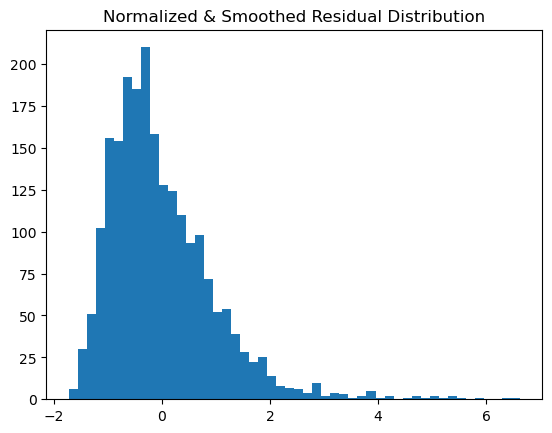

In [21]:
# 4. Visualize transformed residuals

plt.hist(wet_y_res_norm, bins=50)
plt.title('Normalized & Smoothed Residual Distribution')
plt.show()

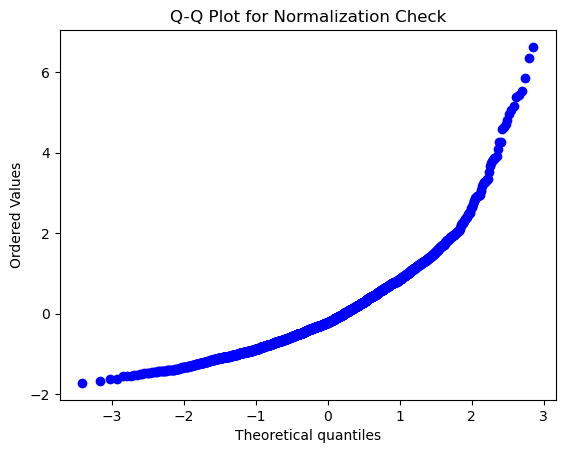

In [22]:
# 5. Recheck QQ Plots

stats.probplot(wet_y_res_norm, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normalization Check")
plt.show()

## Train ARCH-X Model

In [84]:
garch_x_col = 'outflow_m3hr_Lag_1'

In [86]:
# Drop any NaNs from lag alignment
garch_df = pd.concat([wet_splits["wet_X_train"][garch_x_col], wet_y_res_norm], axis=1).dropna()

X = garch_df[garch_x_col] # exogenous predictor (outflow lag 1)
y = garch_df[0]           # smoothed and normalized residuals

In [88]:
# Apply to your data
# result = fit_garch_exog(y.values, X.values)
result = fit_garch_exog(y.values, X.values)

if result.success:
    omega, alpha, beta, gamma = result.x
    print("GARCH(1,1) with Exogenous Variable Results:")
    print(f"omega (constant): {omega:.6f}")
    print(f"alpha (ARCH): {alpha:.6f}")
    print(f"beta (GARCH): {beta:.6f}")
    print(f"gamma (exogenous): {gamma:.6f}")
    print(f"Log-likelihood: {-result.fun:.2f}")
else:
    print("Optimization failed:", result.message)

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


GARCH(1,1) with Exogenous Variable Results:
omega (constant): 0.171583
alpha (ARCH): 0.814533
beta (GARCH): 0.000000
gamma (exogenous): 0.008321
Log-likelihood: -2416.30


### Forecast Volatility on Test Set

In [90]:
x_test = wet_splits["wet_X_test"][garch_x_col]
volatility_forecast = forecast_volatility(result, y.values, x_test) 

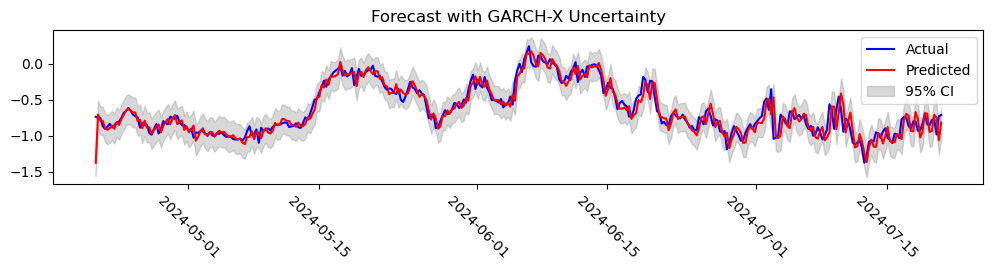

In [208]:
y_pred_test = wet_y_pred
y_test = wet_splits['wet_y_test']

# Create confidence bands
confidence_level = 0.95
ci_bands = create_confidence_bands(y_test, y_pred_test, volatility_forecast, confidence_level)

# Plot everything together
rescaled_vol = rescale(volatility_forecast, wet_y_res.mean(), wet_y_res.std())
cond_vol = plot_forecast_with_uncertainty(y_test, y_pred_test, rescaled_vol)

### Min/Max Estimated Std Analysis

In [196]:
# Raw Variance range on testing dataset

volatility_forecast.min(), volatility_forecast.max()

(0.6615593913417375, 1.069977603840002)

In [200]:
# Rescaled variance range on testing dataset

rescale(volatility_forecast.min(), wet_y_res.mean(), wet_y_res.std()), rescale(volatility_forecast.max(), wet_y_res.mean(), wet_y_res.std())

(0.09290019663002701, 0.10777485297345893)

# Dry Season DDU Model

## Calculate Date Indices

In [94]:
# Extract training dates
dry_date_strings = dry_splits["dry_X_train"].index.strftime('%Y-%m-%d').to_numpy()

## Visualize Residuals

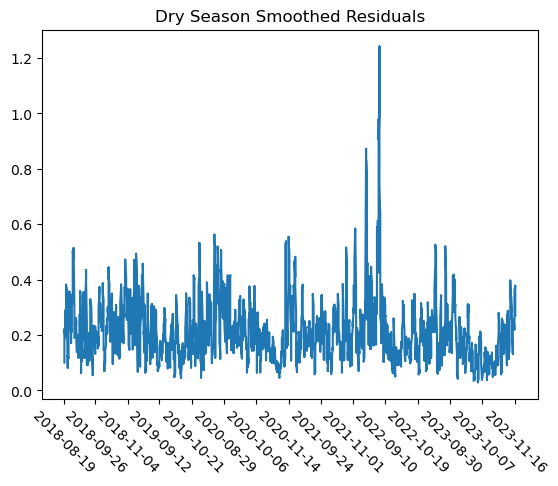

In [97]:
# 1. Take absolute value of residuals 

# 2. Apply a smoothing algorithm 

dry_win = 5

dry_y_res = plot_smoothed_residuals(dry_date_strings, dry_residuals, dry_win, "Dry")

In [99]:
# 3. Normalize residuals 
print(f"Before normalization - Mean: {dry_y_res.mean():.6f}, Std: {dry_y_res.std():.6f}")

dry_y_res_norm = (dry_y_res - dry_y_res.mean()) / dry_y_res.std()
print(f"After normalization - Mean: {dry_y_res_norm.mean():.6f}, Std: {dry_y_res_norm.std():.6f}")

Before normalization - Mean: 0.210965, Std: 0.110301
After normalization - Mean: -0.000000, Std: 1.000000


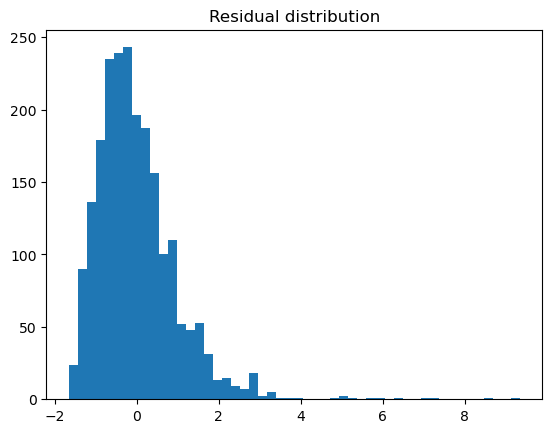

In [101]:
# 4. Visualize transformed residuals

plt.hist(dry_y_res_norm, bins=50)
plt.title('Residual distribution')
plt.show()

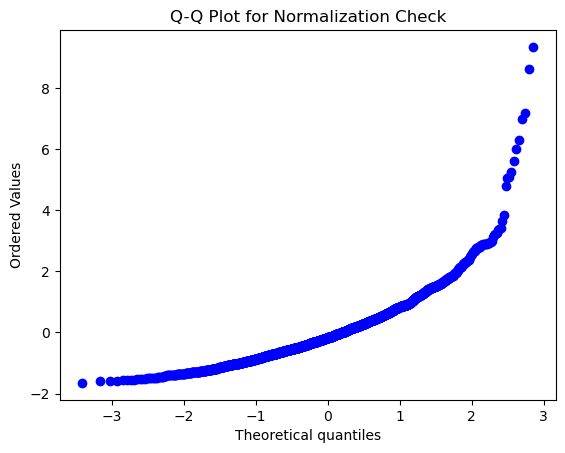

In [37]:
# 5. Recheck QQ Plots

stats.probplot(dry_y_res_norm, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normalization Check")
plt.show()

## Train GARCH Model

In [103]:
# Drop any NaNs from lag alignment
garch_df = pd.concat([dry_splits["dry_X_train"][garch_x_col], dry_y_res_norm], axis=1).dropna()

X = garch_df[garch_x_col] # exogenous predictor (outflow lag 1)
y = garch_df[0]           # smoothed and normalized residuals

In [105]:
# Apply to your data
# result = fit_garch_exog(y.values, X.values)
result = fit_garch_exog(y.values, X.values)

if result.success:
    omega, alpha, beta, gamma = result.x
    print("GARCH(1,1) with Exogenous Variable Results:")
    print(f"omega (constant): {omega:.6f}")
    print(f"alpha (ARCH): {alpha:.6f}")
    print(f"beta (GARCH): {beta:.6f}")
    print(f"gamma (exogenous): {gamma:.6f}")
    print(f"Log-likelihood: {-result.fun:.2f}")
else:
    print("Optimization failed:", result.message)

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


GARCH(1,1) with Exogenous Variable Results:
omega (constant): 0.178503
alpha (ARCH): 0.795736
beta (GARCH): 0.007031
gamma (exogenous): 0.040389
Log-likelihood: -2371.97


### Forecast Volatility on Test Set

In [215]:
x_test = dry_splits["dry_X_test"][garch_x_col]
volatility_forecast = forecast_volatility(result, y.values, x_test) 

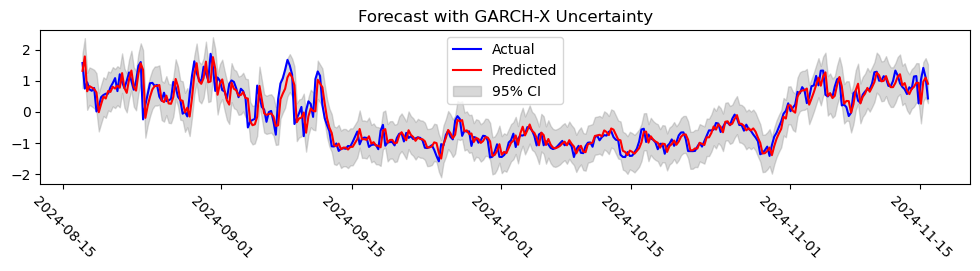

In [217]:
y_pred_test = dry_y_pred
y_test = dry_splits['dry_y_test']

# Create confidence bands
ci_bands = create_confidence_bands(y_test, y_pred_test, volatility_forecast, confidence_level)

# Plot everything together
rescaled_vol = rescale(volatility_forecast, dry_y_res.mean(), dry_y_res.std())
cond_vol = plot_forecast_with_uncertainty(y_test, y_pred_test, rescaled_vol)

In [219]:
# Rescaled variance range on testing dataset

rescale(volatility_forecast.min(), dry_y_res.mean(), dry_y_res.std()), rescale(volatility_forecast.max(), dry_y_res.mean(), dry_y_res.std())

(0.2839359428754885, 0.32898491899683924)